In [1]:
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier
import itertools
from copy import copy
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import KFold
from itertools import combinations
import numpy as np
from matplotlib import pyplot as plt

/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("ml5/train.csv", sep=";")
test = pd.read_csv("ml5/test.csv", sep=";")
test["smoke"] = test["smoke"].apply(lambda x: np.nan if (x == "None")  else int(x))
test["alco"] = test["alco"].apply(lambda x: np.nan if (x == "None")  else int(x))
test["active"] = test["active"].apply(lambda x: np.nan if (x == "None")  else int(x))

In [3]:
def get_int_columns(columns_list):
    int_columns = []
    for f in columns_list:
        if all(data_train[f].dropna().astype("int64").astype(float) == data_train[f].dropna())\
           and (len(data_train[f].value_counts()) > 1):
            int_columns.append(f)
    return int_columns

In [4]:
train.columns

Index([u'id', u'age', u'gender', u'height', u'weight', u'ap_hi', u'ap_lo',
       u'cholesterol', u'gluc', u'smoke', u'alco', u'active', u'cardio'],
      dtype='object')

In [5]:
def null_outliers(df, c_list):
    df = df.copy()
    for c in c_list:
        if len(df[c].value_counts()) != 2:
            mean = df[c].mean()
            std = df[c].std()
            df.loc[np.abs(df[c]-mean)>(3.2*std), c] = np.nan
    return df

def process_table(df):
    df = df.copy()
    df = null_outliers(df, df.columns)
    df["w2dh2"] = df["weight"] * df["weight"] * 1.0 / (df["height"] * df["height"])
    return df

In [6]:
def get_proba(d):
    d = d.astype(float)
    sum_v = sum(d.values)
    for i in d.keys():
        d[i] *= (1.0 / sum_v)
    return d

def find_best_val(val, d):
    keys = d.keys()
    best_val = keys[0]
    min_dist = abs(d[keys[0]] - val)
    for k in keys[1:]:
        dist = abs(d[k] - val)
        if dist < min_dist:
            min_dist = dist
            best_val = k
    return best_val

def get_bad_keys_dict(bad_keys, test_proba_dict, train_proba_dict):
    bad_keys_dict = {}
    for k in bad_keys:
        bad_keys_dict[k] = find_best_val(test_proba_dict[k], train_proba_dict)
    return bad_keys_dict

In [7]:
def get_categorical_features(train, test, c_columns):
    train = train.copy()
    test = test.copy()
    for f in tqdm_notebook(c_columns):
        train_d = get_proba(train[f].value_counts())
        train.loc[train[f].isnull(), f] = np.random.choice(train_d.keys(), size = len(train[train[f].isnull()]), 
                                                           p=train_d.values)
        
        test.loc[test[f].isnull(), f] = np.random.choice(train_d.keys(), size = len(test[test[f].isnull()]), 
                                                           p=train_d.values)
        test_d = get_proba(test[f].value_counts())
        bad_keys = list(set(test_d.keys()).difference(set(train_d.keys())))
        bad_keys_dict = get_bad_keys_dict(bad_keys, test_d, train_d)
        test.loc[test[f].isin(bad_keys), f] = test.loc[test[f].isin(bad_keys), f].apply(lambda x: bad_keys_dict[x])
        
        le = LabelEncoder()
        train[f] = le.fit_transform(train[f])
        test[f] = le.transform(test[f])
        
        enc = OneHotEncoder(sparse=False)
        o_f_train = enc.fit_transform(train[[f]])
        o_f_test = enc.transform(test[[f]])
        column_names = [f + "_" + str(i) for i in range(o_f_train.shape[1])]
        df_t_train = pd.DataFrame(data=o_f_train, columns=column_names)
        df_t_test = pd.DataFrame(data=o_f_test, columns=column_names)
        train = train.join(df_t_train)
        test = test.join(df_t_test)
    return train, test

In [8]:
def get_numeric_features(train, test, n_list, log_f):
    train = train.copy()
    test = test.copy()
    for f in n_list:
        if (f in int_columns):
            v_c = train[f].value_counts()
            train_d = get_proba(v_c)
            
            train.loc[train[f].isnull(), f] = np.random.choice(train_d.keys(), size = len(train[train[f].isnull()]), 
                                                           p=train_d.values)
            test.loc[test[f].isnull(), f] = np.random.choice(train_d.keys(), size = len(test[test[f].isnull()]), 
                                                           p=train_d.values)
        else:
            mean = train[f].astype(float).mean()
            std  = train[f].astype(float).std()
            min_f = train[f].min()
            max_f = train[f].max()
            train.loc[train[f].isnull(), f] = pd.Series(np.random.normal(mean, std, len(train[train[f].isnull()]))).clip(min_f ,max_f).values
            test.loc[test[f].isnull(), f] = pd.Series(np.random.normal(mean, std, len(test[test[f].isnull()]))).clip(min_f, max_f).values
        
        if f in log_f:
            max_train = -train[f].min() + 1
            max_test = -test[f].min() + 1
            train["log_"+f] = train[f].apply(lambda x: np.log(x+max_train))
            test["log_"+f] = test[f].apply(lambda x: np.log(x+max_test))
    
    return train, test

In [9]:
def get_numeric_mean_nan(train, test, n_list, log_f):
    train = train.copy()
    test = test.copy()
    for f in n_list:
        mean = train[f].astype(float).mean()
        train.loc[train[f].isnull(), f] = mean
        test.loc[test[f].isnull(), f] = mean
        if f in log_f:
            min_total = min(train[f].min(), test[f].min())
#            max_train = -train[f].min() + 1
#            max_test = -test[f].min() + 1
            train["log_"+f] = train[f].apply(lambda x: np.log(x - min_total + 1))
            test["log_"+f] = test[f].apply(lambda x: np.log(x - min_total + 1))
    
    return train, test

In [10]:
def get_sp_bool_f(df, f):
    df = df.copy()
    for i, j in combinations(f, 2):
        if i[:5] != j[:5]:
            df[i+"&" +j] = df[i].astype(int) & df[j].astype(int)
            df[i+"|" +j] = df[i].astype(int) | df[j].astype(int)
            df[i+"^" +j] = df[i].astype(int) ^ df[j].astype(int)
    return df

def get_sp_num_f(df, f_list):
    df = df.copy()
    for f in f_list:
        df["sqrt_"+f] = np.sqrt(abs(df[f]))
        df["sqr_"+f] = df[f] * df[f]

    for f1, f2 in tqdm_notebook(combinations(f_list, 2)):
        if (f1 != ("norm_" + f2)) and (f2 != ("norm_" + f1)):
            df[f1+"_sub_"+f2] = df[f1] - df[f2]
            df[f1+"_abs_dif_"+f2] = df[f1] - df[f2]
            df[f1+"_sum_"+f2] = df[f1] + df[f2] 
            df[f1+"_mul_"+f2] = df[f1] * df[f2]
            if len(df[df[f2]==0]) * 1.0 / len(df) < 0.2:
                df[f1+"_div_"+f2] = df[f1].astype(float) / df[f2]
                df[f1+"_div_"+f2] = df[f1+"_div_"+f2].replace(np.inf, np.nan)
                df[f1+"_div_"+f2] = df[f1+"_div_"+f2].fillna(0)
                
            if len(df[df[f1]==0]) * 1.0 / len(df) < 0.2:
                df[f2+"_div_"+f1] = df[f2].astype(float) / df[f1]
                df[f2+"_div_"+f1] = df[f2+"_div_"+f1].replace(np.inf, np.nan)
                df[f2+"_div_"+f1] = df[f2+"_div_"+f1].fillna(0)
                
    return df

In [11]:
def check_c_column(column, c_column_names):
    for c in c_column_names:
        ind = column.find(c + "_")
        if (ind == 0) and column[ind + len(c) + 1:].isdigit():
            return True
    return False

In [12]:
def create_features(train, test, c_columns, n_columns, sp_bin_f=[],
                    sp_c_f=None, fill_mean=False,
                    sp_n_f=None, log_f=[]):
    
    train = train.copy()
    test = test.copy()
    full_f = c_columns + n_columns
    
    train = train[full_f + ["id", "cardio"]]
    
    if "target" in test.columns:
        test = test[full_f + ["id", "cardio"]]
    else:
        test = test[full_f + ["id"]]
        
    train, test = get_categorical_features(train, test, c_columns)

    if not fill_mean:
        train, test = get_numeric_features(train, test, n_columns, log_f)
    else:
        train, test = get_numeric_mean_nan(train, test, n_columns, log_f)
    
    sp_bin_f = list(copy(sp_bin_f))
    
    if sp_c_f is not None:  
        sp_bin_f += [i for i in train.columns if check_c_column(i, sp_c_f)]
        
    if len(sp_bin_f) != 0:
        sp_bin_f = list(set(sp_bin_f))
        
    if sp_bin_f is not None:
        train = get_sp_bool_f(train, sp_bin_f)
        test = get_sp_bool_f(test, sp_bin_f)
      
    if sp_n_f is not None:
        train = get_sp_num_f(train, sp_n_f)
        test = get_sp_num_f(test, sp_n_f)
    
    return train, test

In [13]:
def cv_tt(df, target, cv, c_f_list, n_list, sp_params={}):
    tt = []
    df = df.copy()
    y = df[target]
    data = df.copy()
    
    for itrain, itest in tqdm_notebook(cv, leave = False):
        train_data = data.loc[itrain,:].copy()
        test_data = data.loc[itest,:].copy()
        train_data.reset_index(inplace=True)
        test_data.reset_index(inplace=True)
        train_data, test_data = create_features(train_data, test_data, c_f_list, n_list, **sp_params)
        fold = {"xtrain" : train_data, "ytrain" : y[itrain], 
                "xtest" : test_data, "ytest" : y[itest]}
        tt.append(fold)

    return tt

In [14]:
def fit_predict(clf, xtrain, ytrain, xtest, ytest, clf_params, 
                fit_params, do_scaling, xgbfit, f_l):
    if do_scaling:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)
        
    if xgbfit:
        if ytest is not None:
            fit_params["eval_set"] = \
                [(xtrain, ytrain), (xtest, ytest)]
        else:
            fit_params["eval_set"] = [(xtrain, ytrain)]
   
    c = clf(**clf_params)
    c.fit(xtrain, ytrain, **fit_params)
    
    p_tst = c.predict(xtest)
    pr_tst = c.predict_proba(xtest)[:,1]
    
    if do_scaling:
        a = c.coef_[0][c.coef_[0]!=0]
        b = np.array(f_l)[c.coef_[0]!=0]
        f_weights = sorted(zip(a, b), key = lambda x : abs(x[0]), reverse=True)
    else:
        a = c.feature_importances_[c.feature_importances_ !=0]
        b = np.array(f_l)[c.feature_importances_ !=0]
        f_weights = sorted(zip(a, b), key = lambda x : abs(x[0]), reverse=True)
    
    return f_weights, p_tst, pr_tst

In [15]:
def get_f(all_f, f_names):
    f_l = []
    for f in f_names:
        for i in all_f:
            if (i == f) and (f+"_0" not in all_f):
                f_l.append(i)
                break
            else:
                ind = i.find(f+"_")
                if (ind == 0) and i[ind+len(f)+1:].isdigit():
                    f_l.append(i)
    return f_l

In [16]:
def get_prediction(train, test, f_names, clf_type, clf_params, fit_params, do_scaling, xgbfit, 
                   nnfit=False, lgbm=False, real_test=False):
    y_train = train["cardio"]
    train_data = train.copy()
    
    if not real_test:
        y_test = test["cardio"]
        test_data = test.copy()
    else:
        y_test = None
        test_data = test.copy()
    
    all_f = list(train.columns)
        
    if lgbm:
        f_l = f_names
    else:
        f_l = get_f(all_f, f_names)

    f_weights, p_tst, pr_tst = fit_predict(clf_type, train_data[f_l], y_train, 
                test_data[f_l], y_test, clf_params, 
                fit_params, do_scaling, xgbfit, f_l)
    if not real_test:
        log_loss_score = log_loss(y_test, pr_tst)
    else:
        log_loss_score = None
        
    res = {"p_test" : p_tst, 
           "pr_test" : pr_tst, 
           "log_loss": log_loss_score,
           "f_weights": f_weights}
    
    return res

In [17]:
def cv_fit_predict(clf, cv_tt, f_names, clf_params = {}, fit_params = {}, 
                   do_scaling = False, xgbfit = False, nnfit = False, lgbm = False):
    cv_answer = []
    
    for fold in tqdm_notebook(cv_tt):
        all_f = list(fold["xtrain"].columns)
        
        if lgbm:
            f_l = f_names
        else:
            f_l = get_f(all_f, f_names)
        
        f_weights, p_tst, pr_tst = fit_predict(clf, 
                                               fold["xtrain"][f_l], fold["ytrain"], 
                                               fold["xtest"][f_l], fold["ytest"], 
                                               clf_params, fit_params, do_scaling, xgbfit, f_l)
        
        log_loss_score = log_loss(fold["ytest"], pr_tst)
        print log_loss_score
        tt_answer = {"p_test" : p_tst, "pr_test" : pr_tst, 
                     "log_loss": log_loss_score,
                     "f_weights": f_weights}
        cv_answer.append(tt_answer)
    
    return cv_answer

In [18]:
data_train = process_table(train)
data_test = process_table(test)

In [19]:
int_columns = get_int_columns(data_train.columns)

In [20]:
categorical_f = ["cholesterol", "gluc"]
bin_f = ["gender", "alco", "smoke", "active"]
numeric_f = ["age", "height", "weight", "ap_hi", "ap_lo", "w2dh2"]

In [21]:
sel_c_columns = categorical_f + bin_f
sel_n_columns = numeric_f
sel_sp_bin_f = bin_f
sel_sp_c_f = categorical_f
log_f = numeric_f
sel_sp_n_f = numeric_f

In [22]:
sp_params = {"sp_bin_f": sel_sp_bin_f, "sp_c_f": sel_sp_c_f, "sp_n_f":sel_sp_n_f, "log_f": log_f}

In [23]:
kfold = KFold(n_splits=10)
cv = list(kfold.split(data_train))
tt = cv_tt(data_train, "cardio", cv, categorical_f, bin_f + numeric_f, sp_params=sp_params)

In [24]:
data_train_f, data_test_f = create_features(data_train, data_test, categorical_f, bin_f + numeric_f, **sp_params)

In [25]:
data_train_f.head()

,cholesterol,gluc,gender,alco,smoke,active,age,height,weight,ap_hi,...,ap_hi_sum_w2dh2,ap_hi_mul_w2dh2,ap_hi_div_w2dh2,w2dh2_div_ap_hi,ap_lo_sub_w2dh2,ap_lo_abs_dif_w2dh2,ap_lo_sum_w2dh2,ap_lo_mul_w2dh2,ap_lo_div_w2dh2,w2dh2_div_ap_lo
0,0,0,2,0,0,1,18393.0,168.0,62.0,110.0,...,110.136196,14.981576,807.658689,0.001238,79.863804,79.863804,80.136196,10.895692,587.388137,0.001702
1,2,0,1,0,0,1,20228.0,156.0,85.0,140.0,...,140.296885,41.563938,471.562630,0.002121,89.703115,89.703115,90.296885,26.719675,303.147405,0.003299
2,2,0,1,0,0,0,18857.0,165.0,64.0,130.0,...,130.150450,19.558494,864.074707,0.001157,69.849550,69.849550,70.150450,10.531497,465.270996,0.002149
3,0,0,2,0,0,1,17623.0,169.0,82.0,150.0,...,150.235426,35.313890,637.143070,0.001570,99.764574,99.764574,100.235426,23.542593,424.762046,0.002354
4,0,0,1,0,0,0,17474.0,156.0,56.0,100.0,...,100.128863,12.886259,776.020408,0.001289,59.871137,59.871137,60.128863,7.731755,465.612245,0.002148


In [58]:
from sklearn.manifold import TSNE, SpectralEmbedding, MDS
from sklearn.decomposition import TruncatedSVD

In [33]:
from time import time

In [39]:
X.shape[0]

7000

In [45]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(i),
                 color=plt.cm.Set1(y[i] * 10.),
                 fontdict={'weight': 'bold', 'size': 3})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [40]:
z = X

In [37]:
X = tt[0]["xtest"]
y = tt[0]["ytest"]

/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


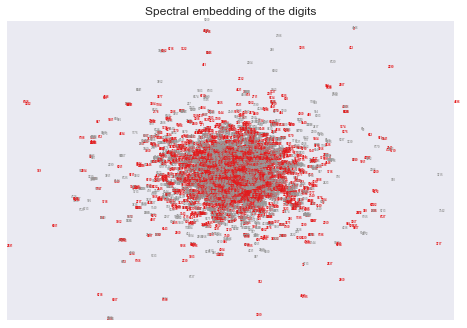

CPU times: user 31.9 s, sys: 3.14 s, total: 35.1 s
Wall time: 27.7 s


In [57]:
%%time
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se,
               "Spectral embedding of the digits (time %.2fs)")


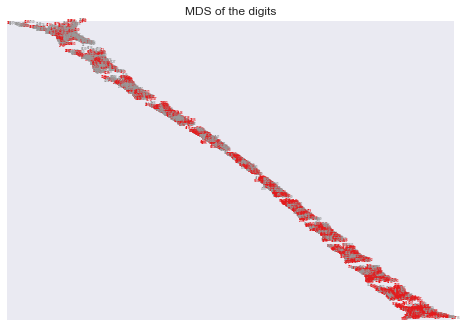

CPU times: user 4min 15s, sys: 1min 41s, total: 5min 57s
Wall time: 3min 53s


In [62]:
%%time
clf = MDS(n_components=2, n_init=1, max_iter=100)
X_se = clf.fit_transform(X)

plot_embedding(X_se,
               "MDS of the digits")
plt.show()

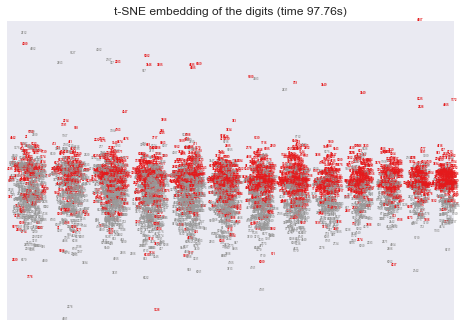

In [50]:
%%time
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(TruncatedSVD(n_components=50).fit_transform(X))

plot_embedding(X_tsne,
               "t-SNE embedding of the digits")

plt.show()

In [ ]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(TruncatedSVD(n_components=50).fit_transform(X))

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

In [ ]:
div_columns = [i for i in data_test_f.columns if "_div_" in i]
mul_columns = [i for i in data_train_f.columns if "_mul_" in i]
sum_columns = [i for i in data_train_f.columns if "_sum_" in i]

In [ ]:
lr_f = [u'cholesterol', u'gluc', u'gender', u'alco', u'smoke', u'active',
       u'age', u'height', u'weight', u'ap_hi', u'ap_lo', "w2dh2"] + div_columns + mul_columns

In [ ]:
lrclf = LogisticRegression(C = 0.000000005, n_jobs = -1, penalty = "l1")


In [ ]:
lrclf.fit(data_train_f[lr_f], data_train_f["cardio"])

In [ ]:
[lr_f[k] for k in np.where(lrclf.coef_ != 0)[1]]

In [ ]:
[lr_f[k] for k in np.where(lrclf.coef_ != 0)[1]]

In [ ]:
lrclf.coef_

In [ ]:
div_columns = [i for i in data_test_f.columns if "_div_" in i]
mul_columns = [i for i in data_train_f.columns if "_mul_" in i]
sum_columns = [i for i in data_train_f.columns if "_sum_" in i]

In [ ]:
lrclf_params = {"C": 0.5, "n_jobs" : -1, "penalty": "l2"}
lrfit_params = {}
lr_f = [u'cholesterol', u'gluc', u'gender', u'alco', u'smoke', u'active',
       u'age', u'height', u'weight', u'ap_hi', u'ap_lo', "w2dh2"] + div_columns + mul_columns
cv_lr_1 = cv_fit_predict(LogisticRegression, tt, lr_f, lrclf_params, lrfit_params, 
                          do_scaling = True, xgbfit = False, lgbm = False)
print "mean_score", np.mean([i["log_loss"] for i in cv_lr_1])

In [63]:
xgbclf_params = {"objective":"binary:logistic", "max_depth":7, "learning_rate":0.01,
                 "n_estimators": 500, "nthread":8, "base_score":0.5, "seed":0, "missing":None}

xgbfit_params = {"eval_metric":"logloss", "early_stopping_rounds":90000, "verbose":True}
xgb_f = [u'cholesterol', u'gluc', u'gender', u'alco', u'smoke', u'active',
       u'age', u'height', u'weight', u'ap_hi', u'ap_lo', "w2dh2"] + div_columns + mul_columns + sum_columns

NameError: name 'div_columns' is not defined

In [64]:
cv_xgb_1 = cv_fit_predict(XGBClassifier, [tt[0]], xgb_f, xgbclf_params, xgbfit_params, 
                          do_scaling = False, xgbfit = True, lgbm = False)

NameError: name 'xgb_f' is not defined

In [65]:
cv_xgb_1[0]["f_weights"][0:10]

NameError: name 'cv_xgb_1' is not defined

In [66]:
print "mean_score", np.mean([i["log_loss"] for i in cv_xgb_1])

mean_score

NameError: name 'cv_xgb_1' is not defined

In [ ]:
print "mean_score", np.mean([i["log_loss"] for i in cv_xgb_1])

In [ ]:
res_test_xgb = get_prediction(data_train_f, data_test_f, xgb_f, XGBClassifier, xgbclf_params, xgbfit_params, 
                              do_scaling = False, xgbfit = True, lgbm=False)

In [ ]:
data_train_f.shape